In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

In [2]:
# structure definition
period_x = 0.357
period_y = 0.357

In [3]:
# Incidence wave
wavelength = 0.530
k0 = np.pi*2 / wavelength

AOI = np.deg2rad(0)
POI = 0

k0x = np.sin(AOI) * np.cos(POI)
k0y = np.sin(AOI) * np.sin(POI)
k0z = np.cos(AOI)

k0v = np.array([k0x, k0y, k0z])

normal_vec = np.array([0, 0, 1], dtype='float')

pol_vec_s = np.cross(normal_vec, k0v)

if k0z==1:
    pol_vec_s = np.array([0, 1, 0], dtype='float')

pol_vec_p = np.cross(pol_vec_s, k0v)

pol_vec_s/=np.sqrt(np.sum(pol_vec_s**2))
pol_vec_p/=np.sqrt(np.sum(pol_vec_p**2))


In [4]:
def vis_vec(v, axis1=0, axis2=2, label=''):
    plt.plot([0, v[axis1]], [0, v[axis2]], '-o', label=label)

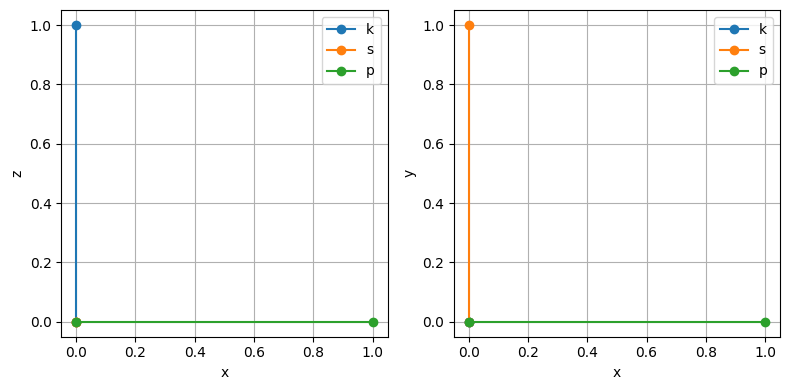

In [5]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
vis_vec(k0v, label='k')
vis_vec(pol_vec_s, label='s')
vis_vec(pol_vec_p, label='p')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
vis_vec(k0v, axis2=1, label='k')
vis_vec(pol_vec_s, axis2=1, label='s')
vis_vec(pol_vec_p, axis2=1, label='p')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()

In [6]:
# Special Frequency
gx = wavelength / period_x
gy = wavelength / period_y

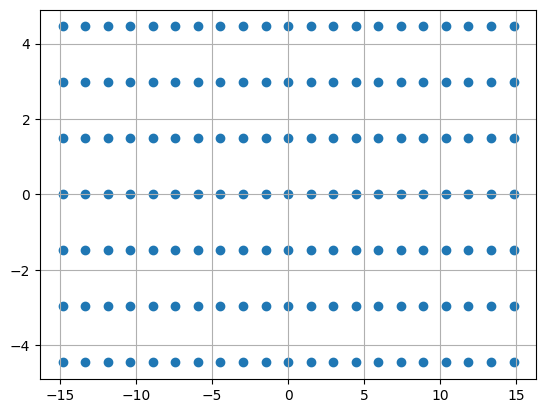

In [7]:

# Harmonics and mode number
num_harmonics_x = 10  # num of x harmonics -num to +num
num_harmonics_y = 3  # num of y harmonics -num to +num

num_modes_x = num_harmonics_x*2+1  # num of x modes
num_modes_y = num_harmonics_y*2+1  # num of y modes

num_modes = num_modes_x * num_modes_y  # total modes


def ind2mode(id):
    id = id % num_modes
    ix = id % num_modes_x
    iy = id // num_modes_x
    mx = ix - num_harmonics_x
    my = iy - num_harmonics_y
    return mx, my


mx, my = ind2mode(np.arange(num_modes))



kx = mx * gx + k0x
ky = my * gy + k0y
plt.scatter(kx, ky)
plt.grid()
plt.show()


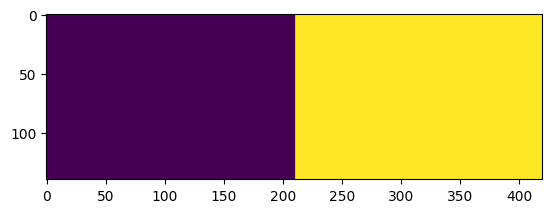

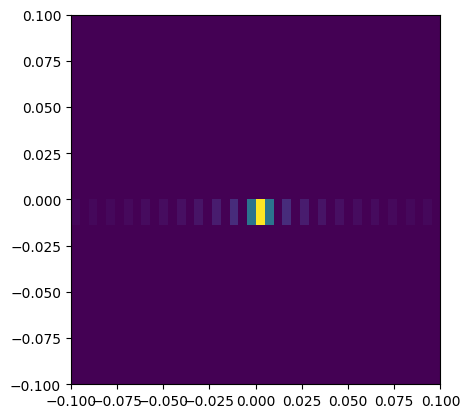

In [8]:
nx = num_modes_x*20
ny = num_modes_y*20
x = np.arange(nx)/nx*period_x
y = np.arange(ny)/ny*period_y
x, y = np.meshgrid(x, y)

# mask = np.sin(x/period_x*np.pi)/2+0.5
mask = x>period_x/2
plt.imshow(mask)
plt.show()

n0 = 1
n1 = 2

conv_er = (n1**2 - n0**2) * mask + n0**2
conv_ur = np.ones([ny, nx])

ft_er = np.fft.fft2(conv_er)
ft_ur = np.fft.fft2(conv_ur)
plt.imshow(np.fft.fftshift(np.abs(ft_er)), extent=[-1, 1, -1, 1])
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])
plt.show()

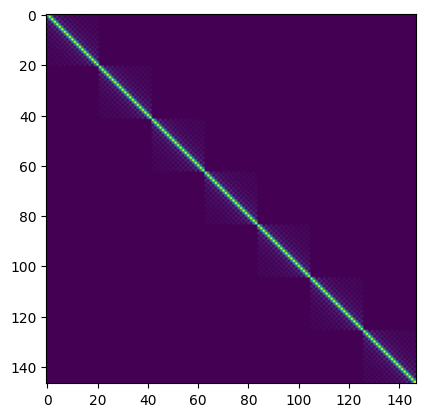

In [9]:
def conv_matrix(a):
    ind_prime = np.arange(num_modes)[None, :]
    ind = np.arange(num_modes)[:, None]
    mx_prime, my_prime = ind2mode(ind_prime)
    mx, my = ind2mode(ind)
    ind_x = (mx-mx_prime)%nx
    ind_y = (my-my_prime)%ny
    conv = a[ind_y, ind_x]/nx/ny
    return conv
conv_er = conv_matrix(ft_er)
conv_ur = conv_matrix(ft_ur)
plt.imshow(np.abs(conv_er))

In [10]:
np.max(np.abs(conv_er))

2.4928571428571433

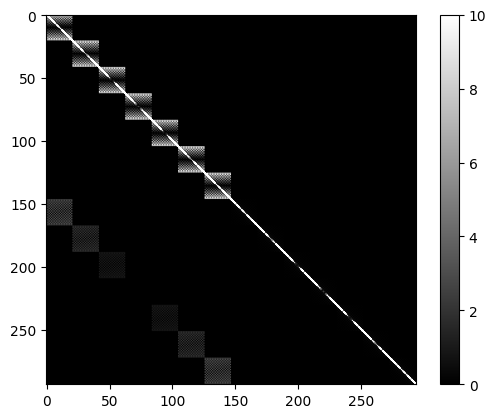

In [11]:
KX = np.diag(kx)
KY = np.diag(ky)


def Pmat(conv_er, conv_ur):
    er_inv_KX = np.linalg.solve(conv_er, KX)
    er_inv_KY = np.linalg.solve(conv_er, KY)
    P11 = KX@er_inv_KY
    P12 = conv_ur-KX@er_inv_KX
    P21 = KY@er_inv_KY-conv_ur
    P22 = -KY@er_inv_KX
    P = np.block([[P11, P12], [P21, P22]])
    return P


def PQmat(conv_er, conv_ur):
    P = Pmat(conv_er, conv_ur)
    Q = Pmat(conv_ur, conv_er)
    return P, Q


P, Q = PQmat(conv_er, np.eye(conv_er.shape[0]))

omega2 = P@Q
plt.imshow(np.abs(omega2), vmax=10, cmap='gray')
plt.colorbar()


In [12]:
def eigen_mode(P, Q):
    omega2 = P@Q
    LAM2, W = LA.eig(omega2)
    LAM = np.sqrt(LAM2)
    V=Q@W@np.diag(1/LAM)
    return W, V, LAM

W, V, LAM = eigen_mode(P, Q)

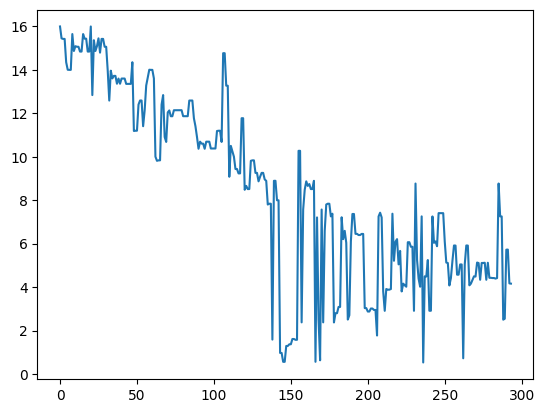

In [13]:
plt.plot(np.abs(LAM))

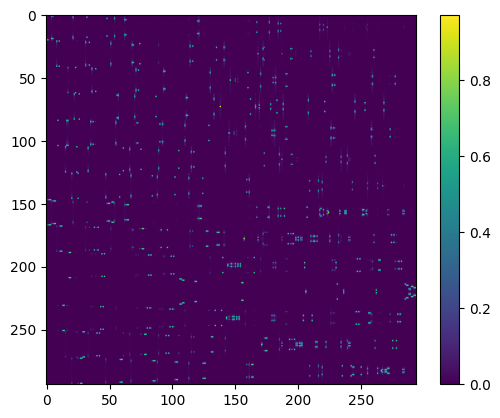

In [14]:
plt.imshow(np.abs(W))
plt.colorbar()

In [15]:
# sorted_indices = np.argsort(np.argmax(np.abs(W), 1))
sorted_indices = np.argsort(-np.abs(LAM))

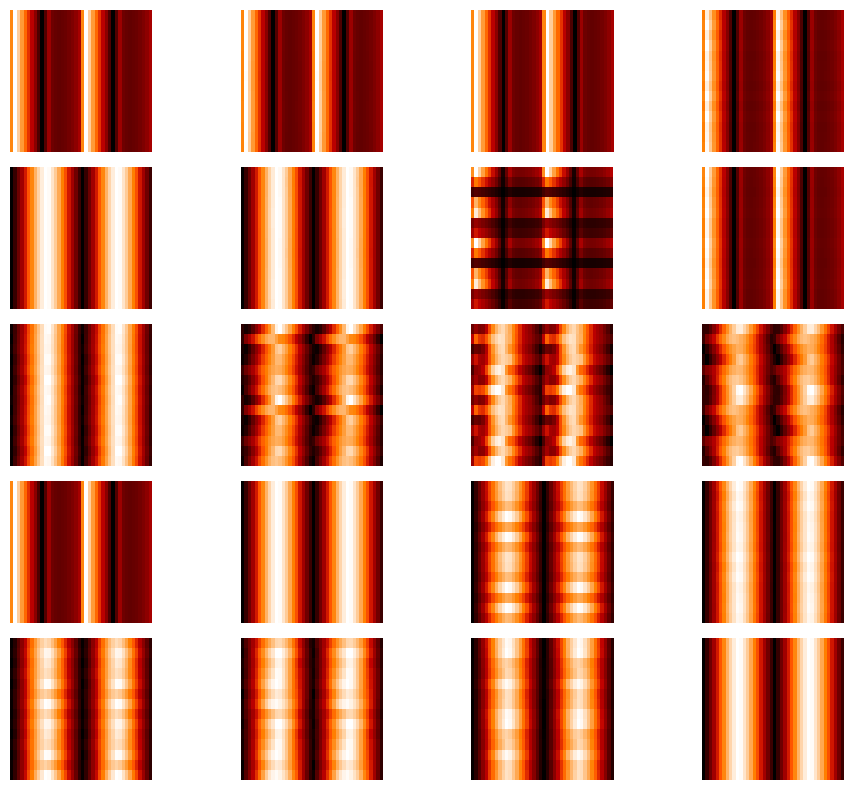

In [16]:
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(5, 4, i+1)
    w = W[:, sorted_indices[i]][:W.shape[0]//2].reshape([num_modes_y, num_modes_x])
    field = np.abs(np.fft.ifft2(w))
    plt.imshow(np.block([
        [field, field],
        [field, field],
    ]), cmap='gist_heat', extent=[0, period_x, 0, period_y])
    plt.axis(False)
plt.tight_layout()

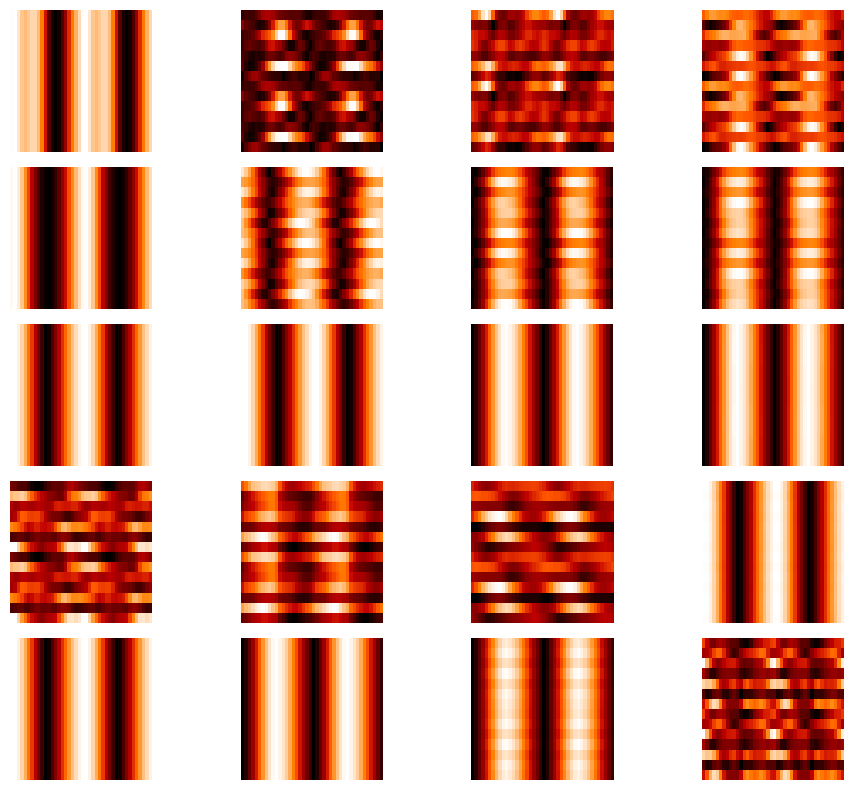

In [17]:
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(5, 4, i+1)
    v = V[:, sorted_indices[i]][:V.shape[0]//2].reshape([num_modes_y, num_modes_x])
    field = np.abs(np.fft.ifft2(v))
    plt.imshow(np.block([
        [field, field],
        [field, field],
    ]), cmap='gist_heat', extent=[0, period_x, 0, period_y])
    plt.axis(False)
plt.tight_layout()

In [18]:
num_modes*2

294

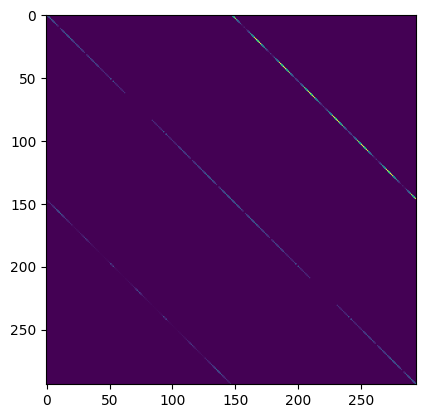

In [19]:
def homogeneous(er, ur):
    n2 = er * ur
    W = np.eye(num_modes*2)
    kz = np.sqrt((n2-kx**2-ky**2).astype('complex'))
    LAM = np.concatenate([1j * kz, 1j * kz])
    V11 = np.diag(kx*ky/kz)
    V12 = np.diag((n2-kx**2)/kz)
    V21 = np.diag((ky**2-n2)/kz)
    V22 = -V11
    V = -1j/ur*np.block([
        [V11, V12],
        [V21, V22],
    ])
    return W, V, LAM

W0, V0, LAM0 = homogeneous(1, 1)
Wref, Vref, LAMref = homogeneous(n0**2, 1)
Wtrn, Vtrn, LAMtrn = homogeneous(n1**2, 1)

plt.imshow(np.abs(Vtrn), vmax=10)


In [20]:
def StarProduct(A, B):
    A11, A12, A21, A22 = A
    B11, B12, B21, B22 = B
    I = np.eye(A11.shape[0])
    
    I_B11A22 = I-B11@A22
    I_A22B11 = I-A22@B11

    S11 = A12@np.linalg.solve(I_B11A22, B11@A21)+A11
    S12 = A12@np.linalg.solve(I_B11A22, B12)
    S21 = B21@np.linalg.solve(I_A22B11, A21)
    S22 = B21@np.linalg.solve(I_A22B11, A22@B12)+B22
    return (S11, S12, S21, S22)


class ScatterMat:
    def __init__(self, value) -> None:
        self.value = value

    def __matmul__(self, other):
        A = self.value
        B = other.value
        S = ScatterMat(StarProduct(A, B))
        return S


In [21]:
def BuildScatter(W, V, LAM, L):
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    X = np.diag(np.exp(-LAM*k0*L))
    AiX = np.linalg.solve(A, X)
    M = A-X@B@AiX@B
    S11 = np.linalg.solve(M, X@B@AiX@A-B)
    S12 = np.linalg.solve(M, X@(A-B@np.linalg.solve(A, B)))
    return ScatterMat((S11, S12, S12, S11))


def BuildScatterRef(W, V):
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    Ai = np.linalg.inv(A)
    S11 = np.linalg.solve(A.T, B.T).T
    S12 = 0.5*(A-S11@B)
    S21 = 2*Ai
    S22 = -np.linalg.solve(A, B)
    return ScatterMat((S11, S12, S21, S22))


def BuildScatterTrn(W, V):
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    Ai = np.linalg.inv(A)
    S11 = -np.linalg.solve(A, B)
    S12 = 2*Ai
    S21 = 0.5*(A-S11@B)
    S22 = np.linalg.solve(A.T, B.T).T
    return ScatterMat((S11, S12, S21, S22))


In [22]:
Sref = BuildScatterRef(Wref, Vref)
S = BuildScatter(W, V, LAM, 0.1)
Strn = BuildScatterTrn(Wtrn, Vtrn)

In [23]:
Sglobal = Sref @ S @ Strn

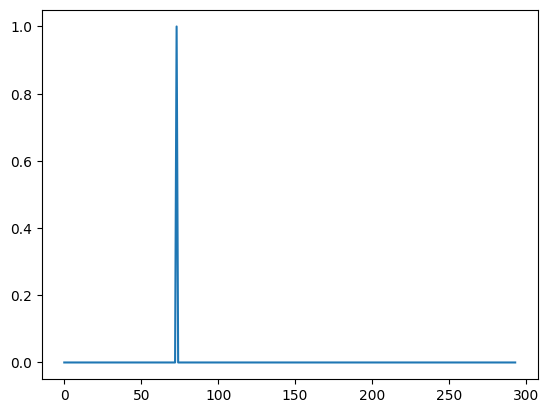

In [24]:
delta = (mx==0)*(my==0)
amp_s = 0
amp_p = 1
pol = pol_vec_p * amp_p + pol_vec_s * amp_s
Einc = np.concatenate([delta*pol[0], delta*pol[1]])[:, None]
plt.plot(Einc)
Eref = Sglobal.value[0]@Einc
Etrn = Sglobal.value[2]@Einc

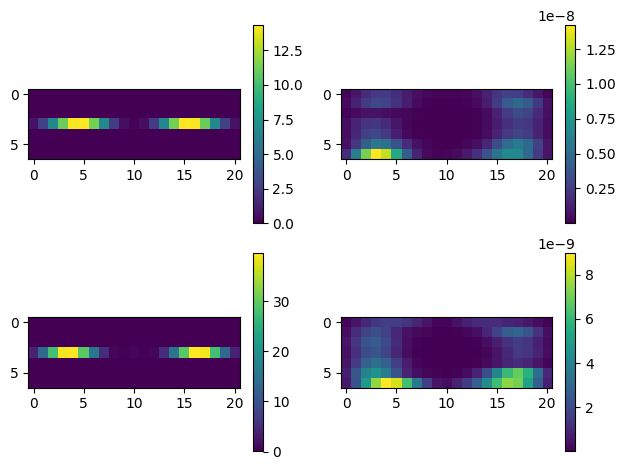

In [25]:
Erefx_2d = np.reshape(Eref[:num_modes], [num_modes_y, num_modes_x])
Erefy_2d = np.reshape(Eref[num_modes:], [num_modes_y, num_modes_x])
Etrnx_2d = np.reshape(Etrn[:num_modes], [num_modes_y, num_modes_x])
Etrny_2d = np.reshape(Etrn[num_modes:], [num_modes_y, num_modes_x])

plt.subplot(2, 2, 1)
plt.imshow(np.abs(Erefx_2d))
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(np.abs(Erefy_2d))
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(np.abs(Etrnx_2d))
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(np.abs(Etrny_2d))
plt.colorbar()
plt.tight_layout()
plt.show()


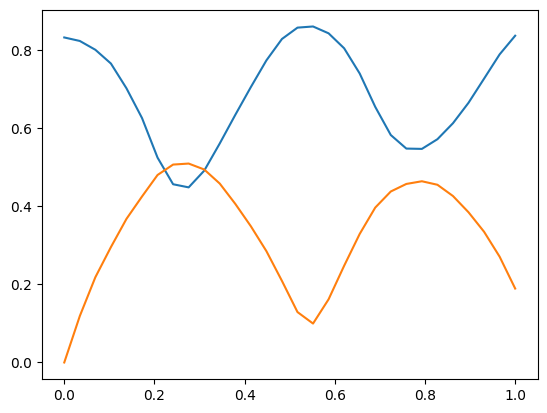

In [26]:
L = np.linspace(0, 1, 30)
T0 = []
T1 = []
for l in L:
    S = BuildScatter(W, V, LAM, l)
    Sglobal = Sref @ S @ Strn
    Etrn = (Sglobal.value[2]@Einc).flatten()
    T0.append(np.abs(np.sum(Etrn[:num_modes]*(mx==0)*(my==0))))
    T1.append(np.abs(np.sum(Etrn[:num_modes]*(mx==1)*(my==0))))
plt.plot(L, T0)
plt.plot(L, T1)